<a href="https://colab.research.google.com/github/Audeon/paintergan/blob/main/Kaggle_Im_Something_of_a_Painter_Myself.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition Work - Im Something of a Painter Myself

**Team**: Acolytes of the Basilisk

**Team Members**: 
*   the protagonist
*   Michael Whitford

**The Challenge**:

A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images. 

# Pip Installs and Data Download
Install all the pip requirements, and next work on Data downloading options. 

In [1]:
!pip install -qq kaggle 

In [2]:
!pip install -qq tensorflow_addons

     |████████████████████████████████| 1.1 MB 4.1 MB/s 


# Kaggle API Downloads
This part allows you to copy your kaggle config files from google drive and use it to download the kaggle competition data.

In [4]:
%env KAGGLE_CONFIG_DIR = /content/

env: KAGGLE_CONFIG_DIR=/content/


In [20]:
! kaggle competitions download -c gan-getting-started -p /content/data/

User cancelled operation


In [1]:
!cp /content/drive/MyDrive/"Colab Notebooks"/config/kaggle.json /content/

# Copy Dataset from Google Drive
This will copy the zip file from the google drive and unzip it into the useful dir. 

In [3]:
!mkdir /content/data/

In [4]:
!cp /content/drive/MyDrive/"Colab Notebooks"/data/gan-getting-started.zip /content/data/

In [ ]:
!unzip /content/data/gan-getting-started.zip -d /content/data/

# Python Package Imports and TPU Setup.

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

This section will check and see if we have TPUs that we can do the processing on. TPUs are faster than GPUs and MANY times faster than CPUs. Luckily colab has TPUs.

**TODO: Must add cloud file system for TPU usage. Running with TPU atm breaks the file loading. Will sort out later, for now run GPU.**




In [7]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

Number of replicas: 1


In [8]:
tf.__version__

'2.8.0'

# Load the TFRecord

In [9]:
data_path = "/content/data/" 

In [10]:
monet_filenames = tf.io.gfile.glob(str(data_path + 'monet_tfrec/*.tfrec'))
photo_filenames = tf.io.gfile.glob(str(data_path + 'photo_tfrec/*.tfrec'))

In [11]:
print(f"Monet TFRecord Files: {len(monet_filenames)}")
print(f"Photo TFRecord Files: {len(photo_filenames)}")

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [12]:
print(f"File Paths: { monet_filenames }")

File Paths: ['/content/data/monet_tfrec/monet00-60.tfrec', '/content/data/monet_tfrec/monet04-60.tfrec', '/content/data/monet_tfrec/monet16-60.tfrec', '/content/data/monet_tfrec/monet12-60.tfrec', '/content/data/monet_tfrec/monet08-60.tfrec']


# Read and Decode Image Data from TFRecord
Next we will read the TFRecord and export the image data, using the decode image function we will also define here. 

In [13]:
image_size = [256,256] #@param

This decodes the image data from the TFRecord, casts the data to a new tensor.

In [14]:
def decode_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = (tf.cast(image, tf.float32)/ 127.5) - 1
  image = tf.reshape(image, [*image_size, 3])
  return image

In [27]:
def read_tfrecord(example):
  tfrecord_format = {
      "image_name": tf.io.FixedLenFeature([], tf.string),
      "image": tf.io.FixedLenFeature([], tf.string),
      "target": tf.io.FixedLenFeature([], tf.string)
  }

  example = tf.io.parse_single_example(example, tfrecord_format)
  image = decode_image(example['image'])
  return image


Define the function to extract the image from the files

In [28]:
def load_dataset(filenames, labeled=True, ordered=False):
  dataset = tf.data.TFRecordDataset(filenames)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
  return dataset

Now we can start to load in the datasets.

In [32]:
monet_ds = load_dataset(monet_filenames, labeled=True).batch(1)
photo_ds = load_dataset(photo_filenames, labeled=True).batch(1)

In [33]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

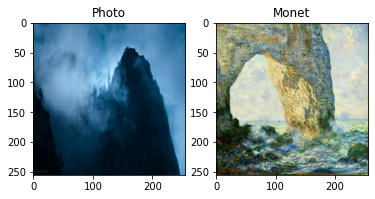

In [34]:
plt.subplot(121)
plt.title("Photo")
plt.imshow(example_photo[0]*0.5 + 0.5)
plt.subplot(122)
plt.title("Monet")
plt.imshow(example_monet[0]*0.5 + 0.5)

# Generator Construction

In [36]:
output_channels = 3

In [35]:
def downsample(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02, 42)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
  result = keras.Sequential()
  result.add(
      layers.Conv2D(filters, size, strides=2, paddings='same', 
      kernel_initalizer=initializer, use_bias=False)
      )
  
  if apply_instancenorm:
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

  # result.add(layers.Activation("Swift"))
  result.add(layers.LeakyReLU())
  return result
